Inorder to run the code, initially uncomment the "# !pip install numpy==1.25.2". Run it, restart the session. Once, restarted comment the line. Run the code normally.

In [ ]:
# 1. Import Required Libraries
import pandas as pd #pandas for data manipulation
# !pip install numpy==1.25.2 --force-reinstall  #uncomment before running code.
import numpy as np #numpy for mathematical functions
import matplotlib.pyplot as plt #matplotlib.pyplot for visualization library
import yfinance as yf #Yahoo Finance is a API wrapper that retrieves historical market data
import copy
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# For decomposition & stationarity testing
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL # Time series decomposition tools for seasonal, trend, and residual components
from statsmodels.tsa.stattools import adfuller, kpss, q_stat # Statistical tests for stationarity on time series data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Visualisation for ACF and PACF
from statsmodels.stats.descriptivestats import sign_test #Statistical tests for stationarity on time series data
import statsmodels.api as sm
import pylab as py

In [ ]:
# For ARIMA modeling
!pip install --upgrade --no-cache-dir pmdarima
import pmdarima as pm # ARIMA forecast modeling
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA # Auto ARIMA for time series forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 138.4 MB/s eta 0:00:00


This defintion is implemented to retrieve stock data for a given time period. Using the Yahoo Finance API, yfiance. The closing price of the stock is visualised.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


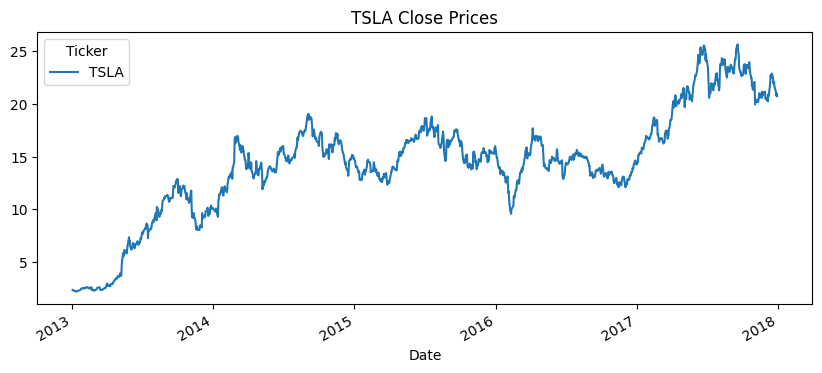

In [ ]:
# Function to Fetch Stock Data (Close Prices Only)
def get_stock_close(stock_code, start, end):
    data = yf.download(stock_code, start=start, end=end)
    close_prices = data['Close']
    close_prices.plot(title=f"{stock_code} Close Prices", figsize=(10,4))
    return close_prices

stock_close = get_stock_close('TSLA', '2013-01-01', '2017-12-31')

This defintion is implemented to apply first order differencing to the time series, helping to remove the linear trends in the series. This definition is used to attain stationarity.

Plot of the series first order differecing is shown.

=== Stationarity Check:  ===


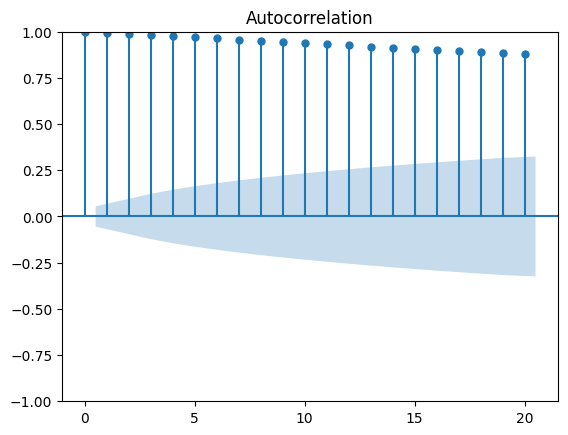

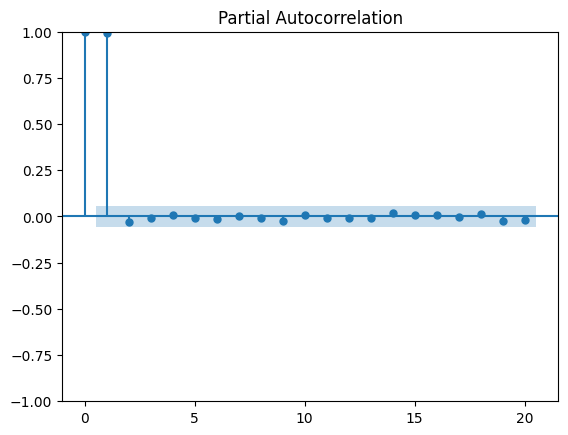

ADF Test: Statistic=-2.126, p-value=0.23429520114760782
=> Not stationary
KPSS Test: Statistic=3.664, p-value=0.01
=> Not stationary

Ljung-Box Test: Statistic=7012.971, p-value=[0. 0. 0. ... 0. 0. 0.]
=> Significant Autocorrelation



<ipython-input-5-0e82b654e1a3>:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(stock_close, regression='c')


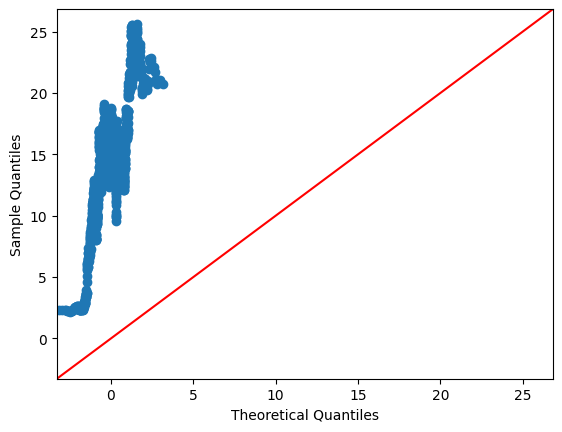

In [ ]:
def check_stationarity(series, title=""):
    print(f"=== Stationarity Check: {title} ===")
    plot_acf(stock_close, lags=20)
    plot_pacf(stock_close, lags=20)
    plt.show()

    adf_stat, adf_p, *_ = adfuller(stock_close)
    print(f"ADF Test: Statistic={adf_stat:.3f}, p-value={adf_p}")
    print("=> Stationary" if adf_p < 0.05 else "=> Not stationary")

    kpss_stat, kpss_p, *_ = kpss(stock_close, regression='c')
    print(f"KPSS Test: Statistic={kpss_stat:.3f}, p-value={kpss_p}")
    print("=> Stationary" if kpss_p > 0.05 else "=> Not stationary")
    print()

#added Ljung-Box
    ljung_box, ljung_box_p, *_= q_stat(stock_close,nobs=len(stock_close))
    print(f"Ljung-Box Test: Statistic={ljung_box[0]:.3f}, p-value={ljung_box_p}")
    print("=> Significantly Random" if ljung_box_p[0] > 0.05 else "=> Significant Autocorrelation")
    print()

# #added difference sign test (number of times (t(i) >t(i-1)))
#     null_median = 0
#     sign_statistic, sign_p, *_ = sign_test(difference_series(stock_close, [1], False), mu0=null_median)
#     print(f"Differencing Sign Test/ Number of increasing values Test: Statistic={sign_statistic:.3f}, p-value={sign_p}")
#     print("=> Too many positive values, not randomly distributed." if sign_p > 0.05 else "=> Significantly Random")
#     print()

#added qq plots
    sm.qqplot(stock_close, line ='45')
    py.show()

check_stationarity(stock_close)

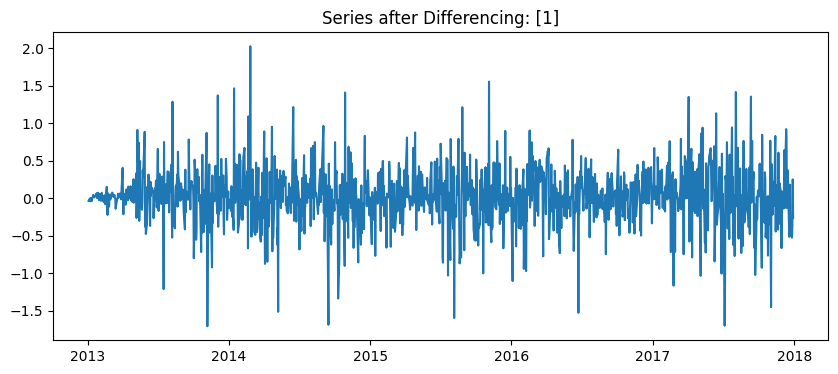

In [ ]:
# Differencing for Stationarity
def difference_series(series, diff_lags=[1], plot=True):
    diff_series = copy.deepcopy(series)
    for lag in diff_lags:
        diff_series = diff_series.diff(lag).dropna()
    if plot:
        plt.figure(figsize=(10,4))
        plt.plot(diff_series)
        plt.title(f"Series after Differencing: {diff_lags}")
    return diff_series

stock_diff = difference_series(stock_close, [1])

This defition is implemented to test the stationarity of the time series.  
**1. ADF Test:**


*   Used to check unit roots in the time series.
*   If p-value <0.05, rejects the null hypothesis and the time series is stationary.

**ADF Syntax:**


*   adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

where;
*   x = series

**2. KPSS Test:**

*   Used to check the trend stationarity in the series.
*   If p-value >0.05, fails to reject the hypothesis and time series is stationary.

**KPSS Syntax:**
*   kpss(x, regression='c', nlags='auto', store=False)

where;
*   x = series

**3. Ljung-Box Test:**

*   Used to check that the residuals are significantly random in the series.
*   If p-value >0.05, fails to reject the hypothesis and time series has significant autocorrilation.

**Ljung-Box Syntax:**
*   q_stat(x, nobs)

where;
*   x = series
*   nobs = optional, number of observations in the sample



=== Stationarity Check: Lag 1 Differencing ===


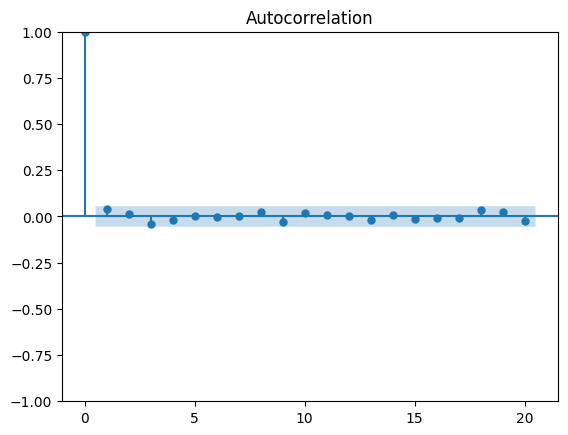

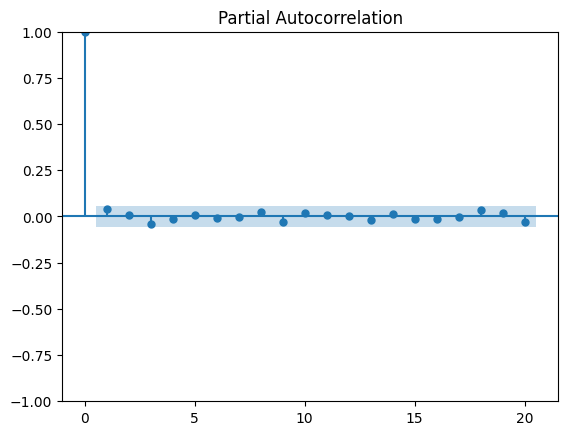

ADF Test: Statistic=-34.096, p-value=0.0
=> Stationary
KPSS Test: Statistic=0.097, p-value=0.1
=> Stationary

Ljung-Box Test: Statistic=1.951, p-value=[0.16249372 0.25682155 0.4336478  ... 0.         0.         0.        ]
=> Significantly Random

Sign Test/ Number of positive values Test: Statistic=28.000, p-value=0.12064791282465168
=> Too many positive values, not randomly distributed.



<ipython-input-7-2bd5794e4f5e>:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(stock_diff, regression='c')


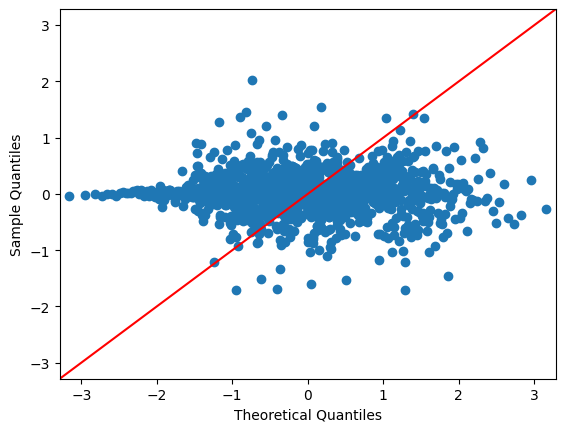

In [ ]:
def check_stationarity(stock_diff, title=""):
    print(f"=== Stationarity Check: {title} ===")
    plot_acf(stock_diff, lags=20)
    plot_pacf(stock_diff, lags=20)
    plt.show()

    adf_stat, adf_p, *_ = adfuller(stock_diff)
    print(f"ADF Test: Statistic={adf_stat:.3f}, p-value={adf_p}")
    print("=> Stationary" if adf_p < 0.05 else "=> Not stationary")

    kpss_stat, kpss_p, *_ = kpss(stock_diff, regression='c')
    print(f"KPSS Test: Statistic={kpss_stat:.3f}, p-value={kpss_p}")
    print("=> Stationary" if kpss_p > 0.05 else "=> Not stationary")
    print()

#added Ljung-Box
    ljung_box, ljung_box_p, *_= q_stat(stock_diff,nobs=len(stock_diff))
    print(f"Ljung-Box Test: Statistic={ljung_box[0]:.3f}, p-value={ljung_box_p}")
    print("=> Significantly Random" if ljung_box_p[0] > 0.05 else "=> Significant Autocorrelation")
    print()

#added difference sign test (number of times (t(i) >t(i-1)))
    null_median = 0
    sign_statistic, sign_p, *_ = sign_test(stock_diff, mu0=null_median)
    print(f"Sign Test/ Number of positive values Test: Statistic={sign_statistic:.3f}, p-value={sign_p}")
    print("=> Too many positive values, not randomly distributed." if sign_p > 0.05 else "=> Significantly Random")
    print()


#added qq plots
    sm.qqplot(stock_diff, line ='45')
    py.show()


check_stationarity(stock_diff, "Lag 1 Differencing")

This definition is implemented to perform time series decomposition methods. Three decomposition methods are implemented :


**1.   Classical Seasonal Decomposition.**


*   Separates time series into trend, seasonal, and residual componenets.
*   Using an additive model, components are added to form the original series.

**Syntax:**


*   seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)

where;
*   x = series


**2.   Seasonal Trend Decomposition. (STL Decomposition)**


*   This is flexible than classical decomposition for non-linear trends.

**Syntax:**


*   STL(endog, period=None, seasonal=7, trend=None, low_pass=None, seasonal_deg=1, trend_deg=1, low_pass_deg=1, robust=False, seasonal_jump=1, trend_jump=1, low_pass_jump=1)

where;
*   endog = series


**3.   Multiple Seasonal Trend Decomposition. (MSTL Decomposition)**


*   Extension of STL that handles multiple seasonal periods simultaneously.

**Syntax:**


*   MSTL(endog, periods=None, windows=None, lmbda=None, iterate=2, stl_kwargs=None)

where;
*   endog = series


Seasonal Decomposition


<Figure size 1200x800 with 0 Axes>

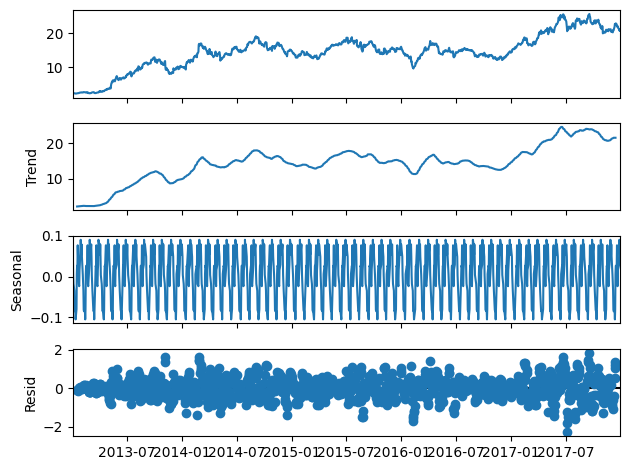

=== Stationarity Check: Seasonal Decomposition Residuals ===


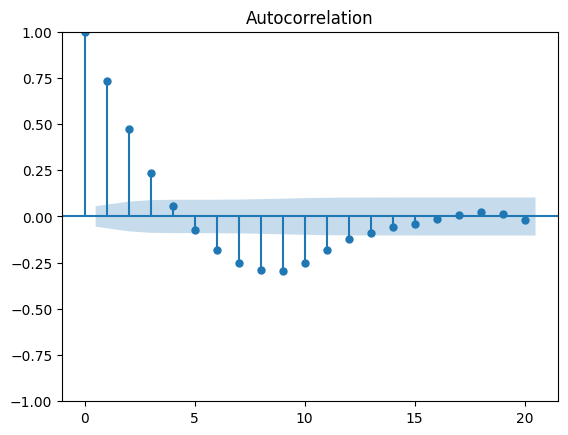

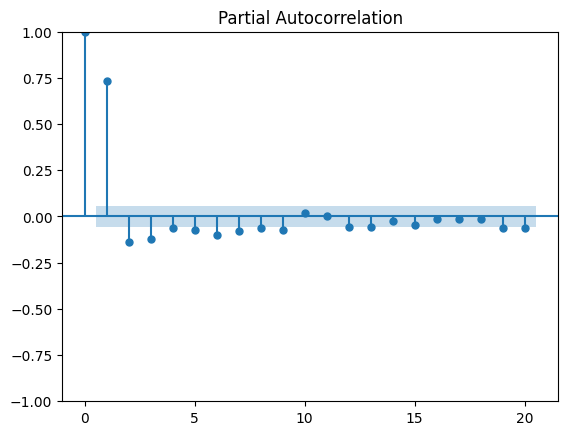

ADF Test: Statistic=-12.191, p-value=1.2853961851573095e-22
=> Stationary
KPSS Test: Statistic=0.006, p-value=0.1
=> Stationary

Ljung-Box Test: Statistic=12.209, p-value=[4.75696259e-04 2.10441646e-05 5.76475403e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
=> Significant Autocorrelation

Sign Test/ Number of positive values Test: Statistic=9.500, p-value=0.6091084847659681
=> Too many positive values, not randomly distributed.



<ipython-input-7-2bd5794e4f5e>:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(stock_diff, regression='c')


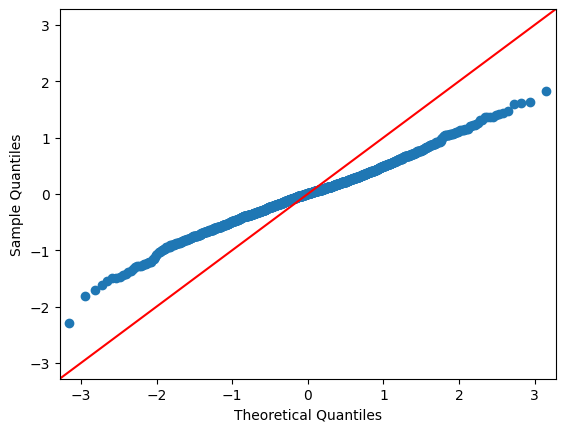

STL Decomposition


<Figure size 1200x800 with 0 Axes>

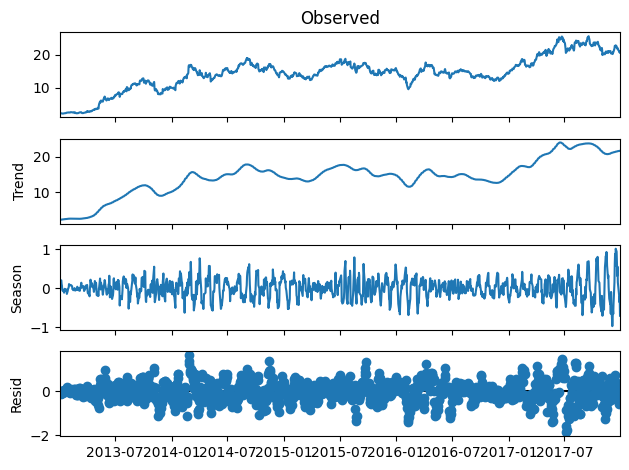

=== Stationarity Check: STL Residuals ===


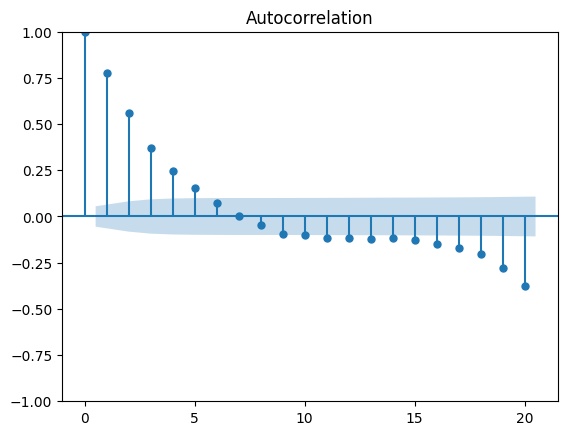

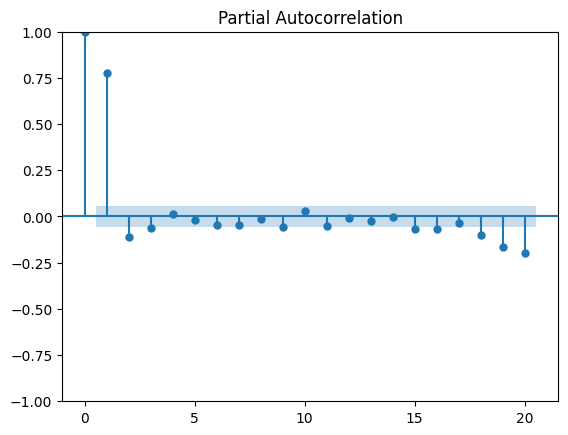

ADF Test: Statistic=-9.530, p-value=2.909755964679522e-16
=> Stationary
KPSS Test: Statistic=0.007, p-value=0.1
=> Stationary

Ljung-Box Test: Statistic=0.042, p-value=[0.83841929 0.96102392 0.07917172 ... 0.         0.         0.        ]
=> Significantly Random

Sign Test/ Number of positive values Test: Statistic=-1.500, p-value=0.9550532168067339
=> Too many positive values, not randomly distributed.



<ipython-input-7-2bd5794e4f5e>:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(stock_diff, regression='c')


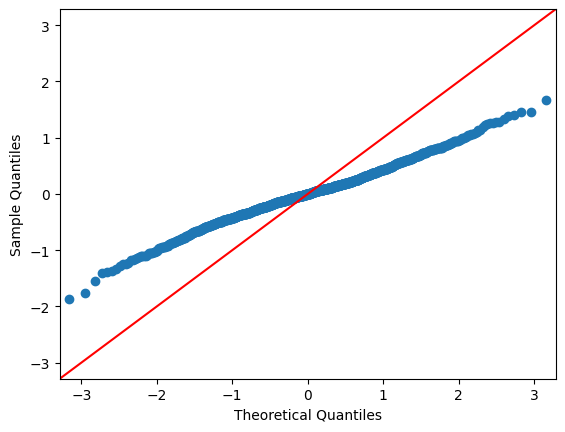

MSTL Decomposition


<Figure size 1200x800 with 0 Axes>

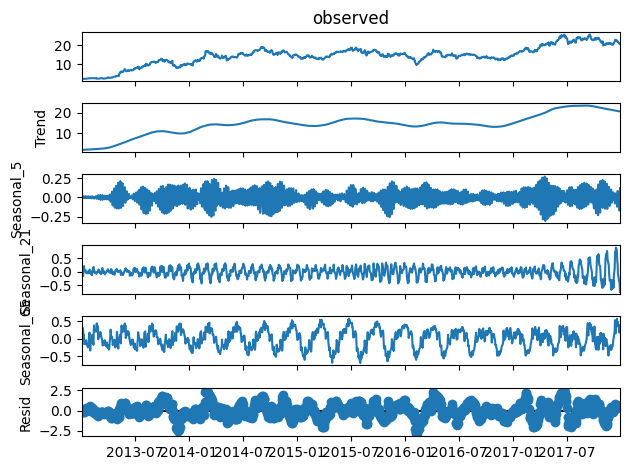

=== Stationarity Check: MSTL Residuals ===


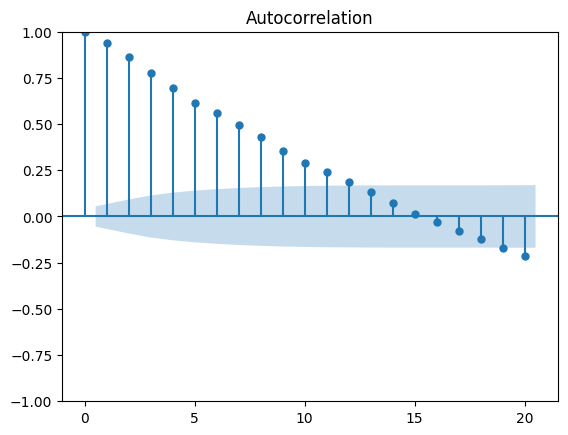

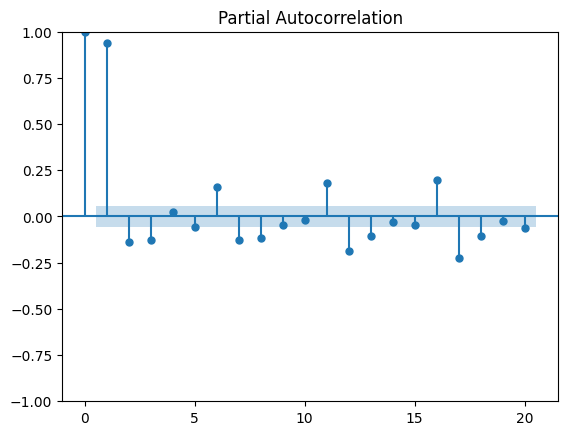

ADF Test: Statistic=-7.953, p-value=3.091539613994231e-12
=> Stationary
KPSS Test: Statistic=0.016, p-value=0.1
=> Stationary

Ljung-Box Test: Statistic=14.510, p-value=[1.39408857e-04 1.63327386e-06 6.97062500e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
=> Significant Autocorrelation

Sign Test/ Number of positive values Test: Statistic=-15.500, p-value=0.39784634775471106
=> Too many positive values, not randomly distributed.



<ipython-input-7-2bd5794e4f5e>:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(stock_diff, regression='c')


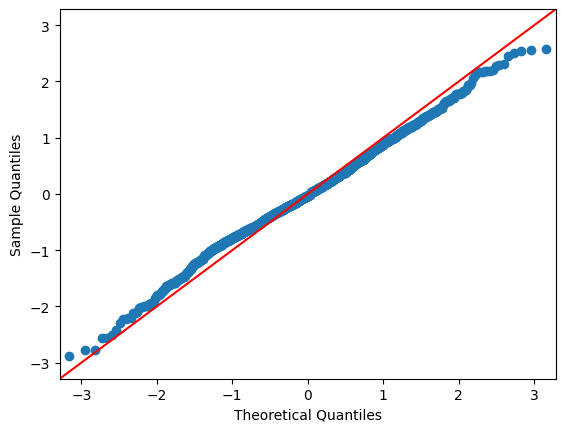

In [ ]:
def run_decompositions(series, periods=[12, 5, 52]):
    print("Seasonal Decomposition")
    result = seasonal_decompose(series, model='additive', period=periods[0])
    plt.figure(figsize=(12, 8))
    result.plot()
    plt.show()
    check_stationarity(result.resid.dropna(), "Seasonal Decomposition Residuals")

    print("STL Decomposition")
    stl = STL(series, period=periods[0])
    result_stl = stl.fit()
    plt.figure(figsize=(12, 8))
    result_stl.plot()
    plt.show()
    check_stationarity(result_stl.resid.dropna(), "STL Residuals")

    print("MSTL Decomposition")
    mstl = MSTL(series, periods=periods)
    plt.figure(figsize=(12, 8))
    result_mstl = mstl.fit()
    result_mstl.plot()
    plt.show()
    check_stationarity(result_mstl.resid.dropna(), "MSTL Residuals")

run_decompositions(stock_close, [21, 5, 65])

In [ ]:
# Define a function to fit ARIMA models and return AIC
def fit_arima_and_get_aic(series, p, d, q):
    model = ARIMA(stock_diff, order=(p, d, q))
    model_fit = model.fit()
    return model_fit.aic

# Compare AIC values for different (p, q) combinations
aic_values = {}
for p in range(3):
    for q in range(3):
        aic = fit_arima_and_get_aic(stock_diff, p, 0, q)
        aic_values[(p, q)] = aic
        print(f"ARIMA({p},0,{q}) AIC: {aic}")

# Find the best (p, q) combination
best_pq = min(aic_values, key=aic_values.get)
print(f"Best (p, q) combination: {best_pq} with AIC: {aic_values[best_pq]}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0,0,0) AIC: 1207.1044341588845


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0,0,1) AIC: 1207.32736173084


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0,0,2) AIC: 1209.0568585749538


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1,0,0) AIC: 1207.283918499143
ARIMA(1,0,1) AIC: 1209.2436489437687


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1,0,2) AIC: 1209.9977633909639


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2,0,0) AIC: 1209.1565646569525


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2,0,1) AIC: 1210.0080073776785


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2,0,2) AIC: 1206.151289786401
Best (p, q) combination: (2, 2) with AIC: 1206.151289786401


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


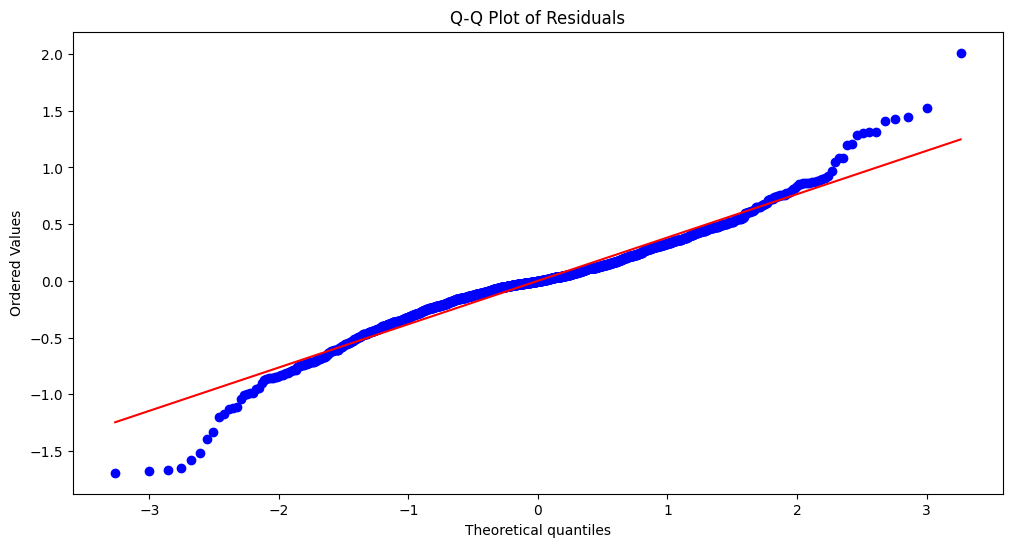

Ljung-Box Test:
     lb_stat  lb_pvalue
10  5.300245    0.87024


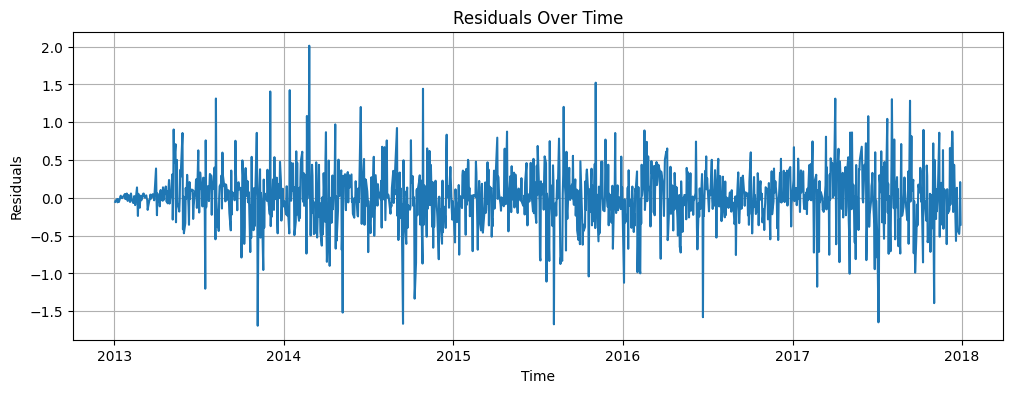

In [ ]:
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fit the ARIMA(2,0,2) model
model = ARIMA(stock_diff, order=(2, 0, 2))
model_fit = model.fit()

# Get residuals
residuals = model_fit.resid

# 1. Normality Check: Q-Q Plot
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 2. Autocorrelation Check: Ljung-Box Test
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test:")
print(lb_test)

# 3. Homoscedasticity Check: Plot Residuals
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

**1. ARIMA Modelling**

Creates an ARIMA(2,0,2) model on the differenced data.

*   p = 2; Auto-regressive term.
*   d = 0; Differencing term.
*   q = 2; Moving-Average terms.

**Syntax:**

*   ARIMA(endog, order=(p,d,q), seasonal_order=(P,D,Q,s), trend='c', enforce_stationarity=True, enforce_invertibility=True)

where;
*   endog = series

**2. Model Fit**

Creates an ARIMA(2,0,2) model on the differenced data.

*   p = 2; Auto-regressive term.
*   d = 0; Differencing term.
*   q = 2; Moving-Average terms.

**Syntax:**

*   ARIMA(endog, order=(p,d,q), seasonal_order=(P,D,Q,s), trend='c', enforce_stationarity=True, enforce_invertibility=True)

where;
*   endog = series

In [ ]:
# Manual ARIMA

model = ARIMA(stock_close, order=(2,1,2))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


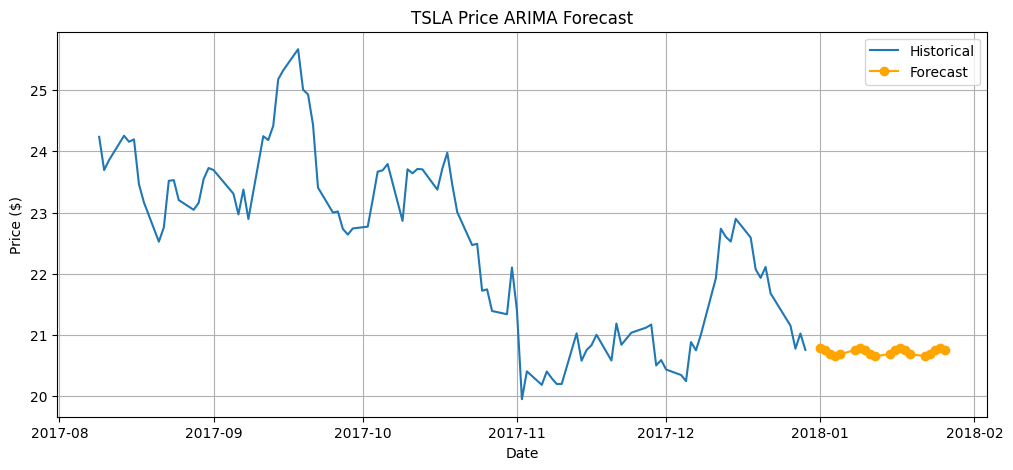

In [ ]:
# Manual ARIMA Forecast
n_steps = 20
forecast_obj = model_fit.get_forecast(steps=n_steps)
forecast_values = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# Build forecast index
forecast_index = pd.date_range(start=stock_close.index[-1] + pd.offsets.BDay(1), periods=n_steps, freq='B')

# Plot
plt.figure(figsize=(12, 5))
plt.plot(stock_close[-100:], label='Historical')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange', marker='o')
# plt.fill_between(forecast_index, conf_int['lower Close'], conf_int['upper Close'], color='orange', alpha=0.2)
plt.title('TSLA Price ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Forecasted Prices
print("Stock series info:")
ManualArima_forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecast': forecast_values})
print(ManualArima_forecast_df)

Stock series info:
           Date   Forecast
1259 2018-01-01  20.789091
1260 2018-01-02  20.751142
1261 2018-01-03  20.681584
1262 2018-01-04  20.649884
1263 2018-01-05  20.686847
1264 2018-01-08  20.754715
1265 2018-01-09  20.785708
1266 2018-01-10  20.749704
1267 2018-01-11  20.683485
1268 2018-01-12  20.653184
1269 2018-01-15  20.688253
1270 2018-01-16  20.752864
1271 2018-01-17  20.782488
1272 2018-01-18  20.748330
1273 2018-01-19  20.685288
1274 2018-01-22  20.656326
1275 2018-01-23  20.689597
1276 2018-01-24  20.751107
1277 2018-01-25  20.779422
1278 2018-01-26  20.747015


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/di

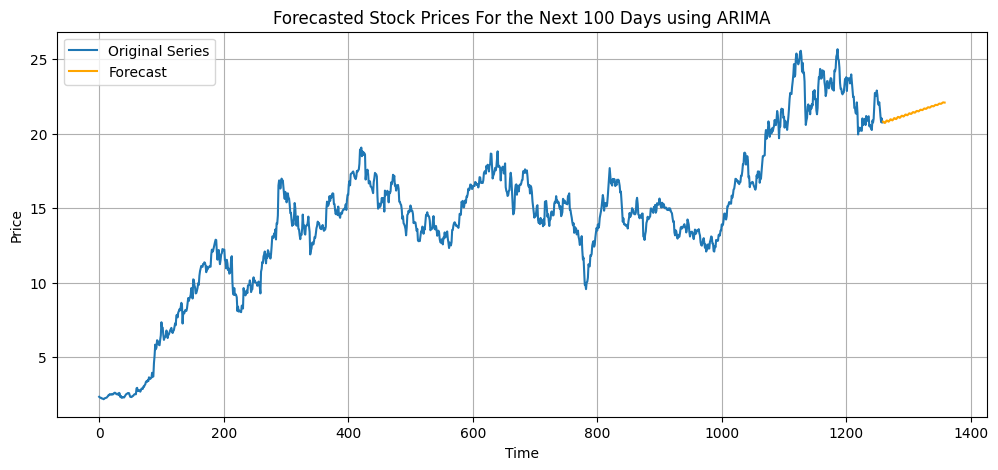

In [ ]:
# Forecast N future steps of differenced values
model = ARIMA(stock_diff, order=(2,0,2))
model_fit = model.fit()

n_steps = 100
forecast_diff = model_fit.forecast(steps=n_steps)

forecast_actual = np.r_[stock_close.iloc[-1], forecast_diff].cumsum()[1:]

forecast_index = np.arange(len(stock_close), len(stock_close) + n_steps)
plt.figure(figsize=(12, 5))
plt.plot(stock_close.values, label='Original Series')
plt.plot(forecast_index, forecast_actual, label='Forecast', color='orange')
plt.title('Forecasted Stock Prices For the Next 100 Days using ARIMA')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Recommended Approach: Auto ARIMA on Original Series
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1211.560, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1207.104, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1207.284, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1207.327, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1206.869, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1209.244, Time=0.99 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.732 seconds


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


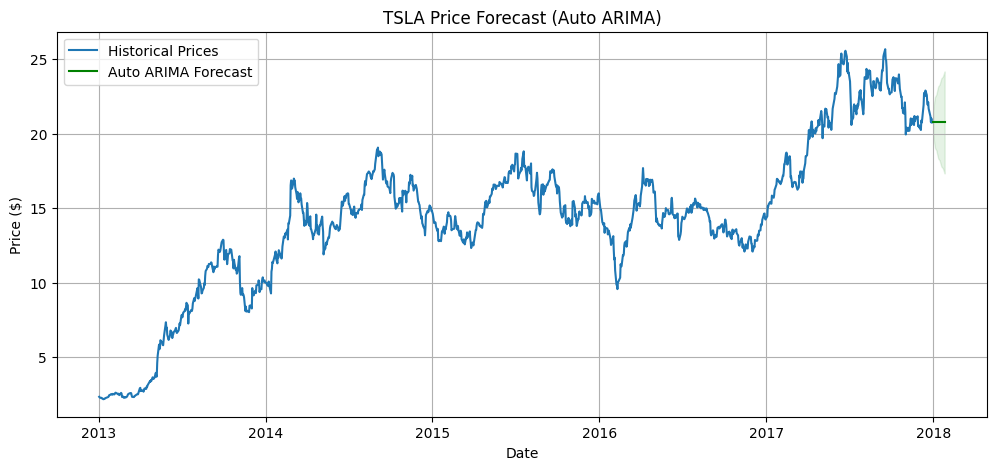

In [ ]:
# Auto ARIMA Model Fit and Forecast

print("\nRecommended Approach: Auto ARIMA on Original Series")
auto_model = pm.auto_arima(
    stock_close,  # Use the original series
    seasonal=False,
    trace=True,
    stepwise=True,
    suppress_warnings=True
)

forecast, conf_int = auto_model.predict(
    n_periods=20,
    return_conf_int=True,
    alpha=0.05
)

forecast_dates_auto = pd.date_range(
    start=stock_close.index[-1] + pd.Timedelta(days=1),
    periods=20,
    freq='B'
)

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(stock_close, label='Historical Prices')
plt.plot(forecast_dates_auto, forecast, label='Auto ARIMA Forecast', color='green')
plt.fill_between(forecast_dates_auto,
                 conf_int[:, 0],
                 conf_int[:, 1],
                 color='green', alpha=0.1)
plt.title('TSLA Price Forecast (Auto ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Auto ARIMA Summary
auto_model = pm.auto_arima(stock_close)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -602.435
Date:                Fri, 02 May 2025   AIC                           1206.869
Time:                        17:41:15   BIC                           1212.007
Sample:                             0   HQIC                          1208.800
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1526      0.004     38.937      0.000       0.145       0.160
===================================================================================
Ljung-Box (L1) (Q):                   1.82   Jarque-Bera (JB):               429.22
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.14
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# AIC Comparisons between Manual ARIMA and Auto ARIMA
from statsmodels.tsa.arima.model import ARIMA

manual_model = ARIMA(stock_diff, order=(2,0,2)).fit()
print("Manual AIC:", manual_model.aic)
print("Auto AIC:", auto_model.aic())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Manual AIC: 1206.151289786401
Auto AIC: 1206.8694553746382


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Summary compasrion of Manual and Auto ARIMA

def summarize_arima(model_fit, forecast, conf_int=None, steps=20):
    print("=== ARIMA Model Summary ===")
    print(model_fit.summary())

    forecast_dates = pd.date_range(start=stock_close.index[-1] + pd.Timedelta(days=1), periods=steps, freq='B')

    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecast': forecast
    })

    if conf_int is not None:
        forecast_df['Lower_CI'] = conf_int[:, 0]
        forecast_df['Upper_CI'] = conf_int[:, 1]

    forecast_df.set_index('Date', inplace=True)
    return forecast_df

In [ ]:
# For manual ARIMA
forecast_diff = model_fit.forecast(steps=20)
forecast_manual = np.r_[stock_close.iloc[-1], forecast_diff].cumsum()[1:]
forecast_df_manual = summarize_arima(model_fit, forecast_manual)

# For auto_arima
forecast_auto, conf_int_auto = auto_model.predict(n_periods=20, return_conf_int=True)
forecast_df_auto = summarize_arima(auto_model, forecast_auto, conf_int=conf_int_auto)

=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 1258
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -597.076
Date:                Fri, 02 May 2025   AIC                           1206.151
Time:                        17:41:17   BIC                           1236.975
Sample:                             0   HQIC                          1217.735
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0138      0.011      1.247      0.212      -0.008       0.036
ar.L1          0.9942      0.020     49.310      0.000       0.955       1.034
ar.L2         -0.9792   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# ARCH LM Test
from statsmodels.stats.diagnostic import het_arch

# Perform ARCH LM test on model residuals
arch_test = het_arch(stock_diff)  # Test using 10 lags

# Create a more informative results display
arch_results = pd.DataFrame({
    'Test Statistic': [arch_test[0]],
    'P-Value': [arch_test[1]],
    'F-Statistic': [arch_test[2]],
    'F P-Value': [arch_test[3]]
}, index=['ARCH LM Test'])

print("ARCH Test for Heteroskedasticity:")
print(arch_results)
print("\nNull Hypothesis: No ARCH effects (homoskedasticity)")
print(f"Conclusion: {'Reject' if arch_test[1] < 0.05 else 'Fail to reject'} null hypothesis at 5% significance level")

# If ARCH effects are detected, recommend next steps
if arch_test[1] < 0.05:
    print("\nRecommendation: Consider using GARCH or other volatility models to account for heteroskedasticity")
else:
    print("\nRecommendation: No significant ARCH effects detected, homoskedastic assumption is reasonable")

ARCH Test for Heteroskedasticity:
              Test Statistic   P-Value  F-Statistic  F P-Value
ARCH LM Test       18.347596  0.049376     1.845723   0.048882

Null Hypothesis: No ARCH effects (homoskedasticity)
Conclusion: Reject null hypothesis at 5% significance level

Recommendation: Consider using GARCH or other volatility models to account for heteroskedasticity


GARCH Modeling

In [ ]:
# Manual ARIMA

model = ARIMA(stock_diff, order=(2,0,2))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# GARCH Modeling
!pip install arch
from arch import arch_model
residuals = model_fit.resid

garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit()

n_steps = 100
garch_forecast = garch_fit.forecast(horizon=n_steps)

vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

forecast_diff_100 = model_fit.forecast(steps=n_steps)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4693564.280916812
Iteration:      2,   Func. Count:     15,   Neg. LLF: 23064.359052143893
Iteration:      3,   Func. Count:     21,   Neg. LLF: 2492784.65718298
Iteration:      4,   Func. Count:     30,   Neg. LLF: 22571.59234274189
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2385956.22913509
Iteration:      6,   Func. Count:     45,   Neg. LLF: 33460.45200807466
Iteration:      7,   Func. Count:     51,   Neg. LLF: 687612.5612697778
Iteration:      8,   Func. Count:     60,   Neg. LLF: 5333.3830477804
Iteration:      9,   Func. Count:     66,   Neg. LLF: 7767.652271461576
Iteration:     10,   Func. Count:     75,   Neg. LLF: 244633.96722765992
Iteration:     11,   Func. Count:     83,   Neg. LLF: 557.4843735200723
Iteration:     12,   Func. Count:     89,   Neg. LLF: 627.8123168507138
Iteration:     13,   Func. Count:     95,   Neg. LLF: 108772.20985907363
Iteration:     14,   Func. Count:    102,   Neg. LLF: 524.0588399

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# ARIMA mean + GARCH volatility shocks
np.random.seed(42)
random_shocks = np.random.normal(0, 1, n_steps)

forecast_prices = [stock_close.iloc[-1]]

for i in range(n_steps):

    mean_increment = forecast_diff_100.iloc[i]
    drift = model_fit.params.get('const', 0)

    shock = vol_forecast[i] * random_shocks[i]

    next_price = forecast_prices[-1] + mean_increment + drift + shock
    forecast_prices.append(next_price)

forecast_prices = forecast_prices[1:]

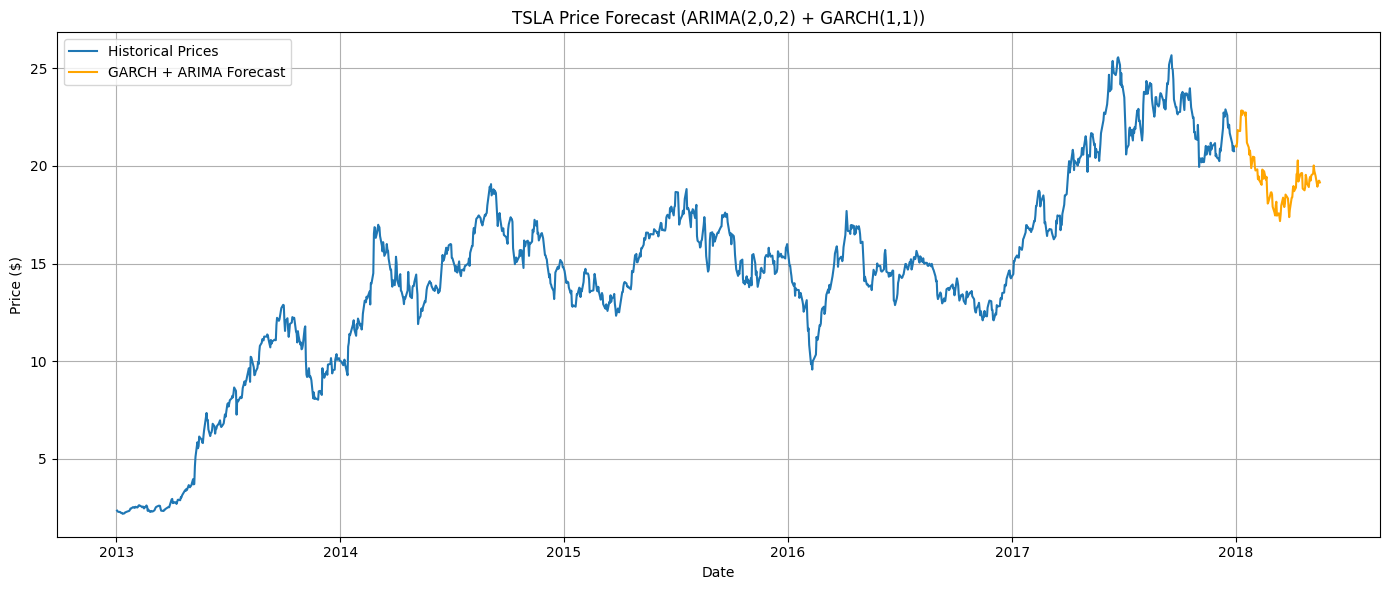

In [ ]:
# GARCH + ARIMA(2, 0, 2) Forecast
forecast_dates_100 = pd.date_range(start=stock_close.index[-1], periods=n_steps + 1, freq='B')[1:]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(stock_close, label='Historical Prices')
plt.plot(forecast_dates_100, forecast_prices, label='GARCH + ARIMA Forecast', color='orange')
plt.title('TSLA Price Forecast (ARIMA(2,0,2) + GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


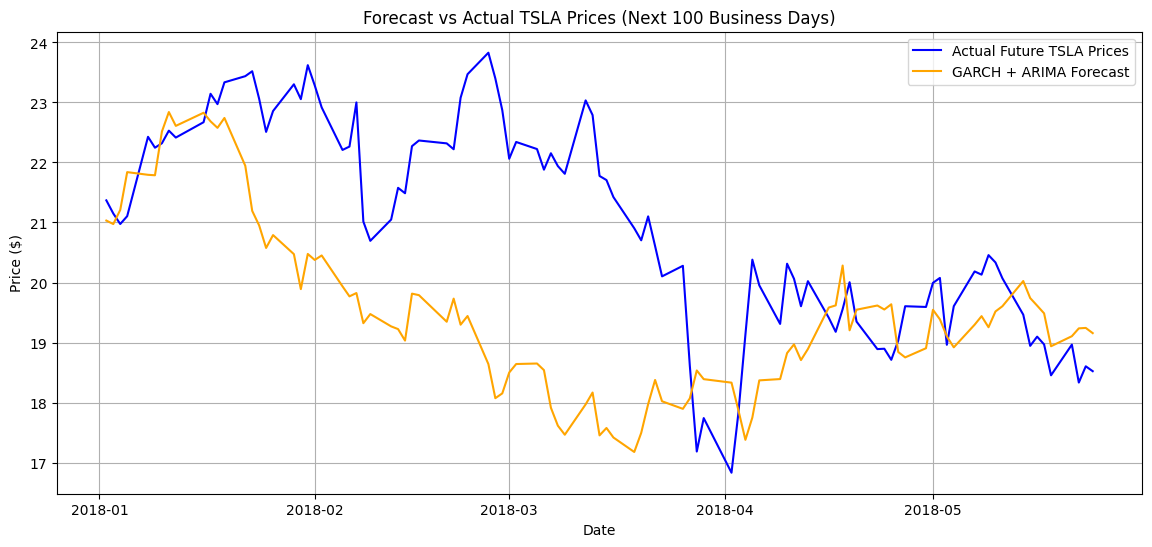

MAE: 1.794
RMSE: 2.304


In [ ]:
#Forecasting for the next 100 days and comparing with real time values

real_future = yf.download('TSLA', start='2018-01-01', end='2018-06-01')
real_close = real_future['Close']

real_close = real_close.iloc[:100]

forecast_series = pd.Series(forecast_prices, index=real_close.index)

plt.figure(figsize=(14,6))
plt.plot(real_close, label='Actual Future TSLA Prices', color='blue')
plt.plot(forecast_series, label='GARCH + ARIMA Forecast', color='orange')
plt.title('Forecast vs Actual TSLA Prices (Next 100 Business Days)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(real_close, forecast_series)
rmse = np.sqrt(mean_squared_error(real_close, forecast_series))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

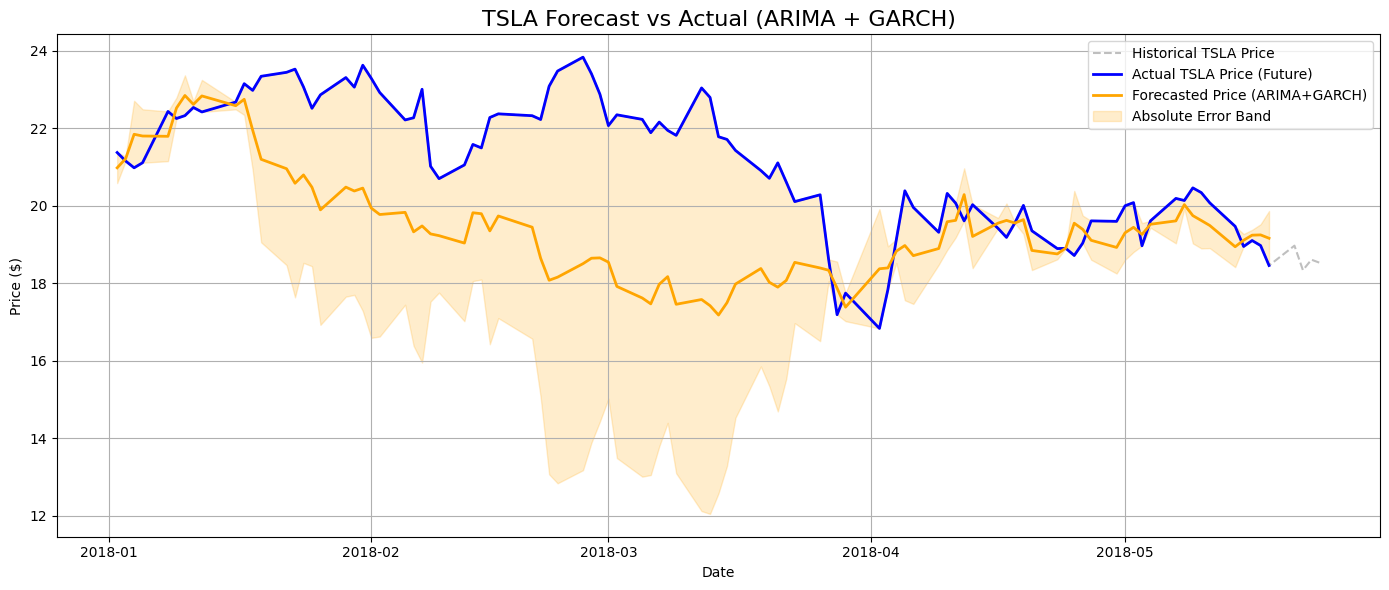

In [ ]:
forecast_dates_garch = pd.date_range(start=stock_close.index[-1] + pd.Timedelta(days=1),
                                     periods=100,
                                     freq='B')
forecast_series = pd.Series(forecast_prices, index=forecast_dates_garch)
common_index = real_close.index.intersection(forecast_series.index)

real_vals = real_close.loc[common_index].astype(float).values.flatten()
forecast_vals = forecast_series.loc[common_index].astype(float).values.flatten()
abs_error = np.abs(real_vals - forecast_vals)

plt.figure(figsize=(14,6))
plt.plot(real_close, label='Historical TSLA Price', color='gray', linestyle='--', alpha=0.5)
plt.plot(common_index, real_vals, label='Actual TSLA Price (Future)', color='blue', linewidth=2)
plt.plot(common_index, forecast_vals, label='Forecasted Price (ARIMA+GARCH)', color='orange', linewidth=2)

plt.fill_between(common_index,
                 forecast_vals - abs_error,
                 forecast_vals + abs_error,
                 color='orange', alpha=0.2, label='Absolute Error Band')

plt.title('TSLA Forecast vs Actual (ARIMA + GARCH)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Text(0.5, 1.0, 'Non-Linear Forecast with Volatility Clustering')

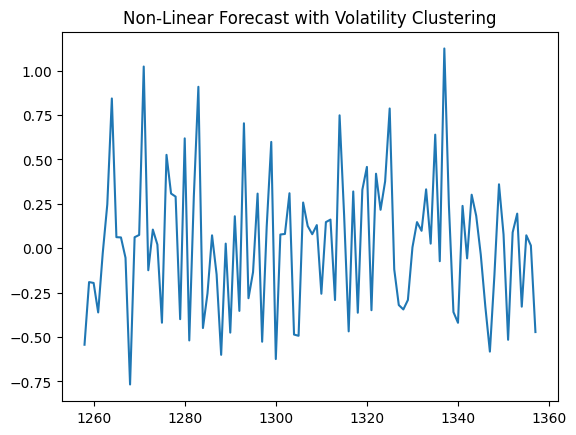

In [ ]:
# GARCH Volatility clustering

arima_resid = model_fit.resid

garch = arch_model(arima_resid, vol='GARCH', p=1, q=1)
garch_fit = garch.fit(disp='off')

vol_forecast = garch_fit.forecast(horizon=100, reindex=False)

arima_forecast = model_fit.forecast(steps=100)

nonlin_forecast = (
    arima_forecast +
    np.random.normal(0, np.sqrt(vol_forecast.variance.values[-1,:]),
    100)
)

plt.plot(nonlin_forecast, label='ARIMA-GARCH Forecast')
plt.title('Non-Linear Forecast with Volatility Clustering')

In [ ]:
# GARCH Summary

def summarize_garch(garch_fit, vol_forecast):
    print("=== GARCH(1,1) Model Summary ===")
    print(garch_fit.summary())

    volatility_df = pd.DataFrame({
        'Date': pd.date_range(start=stock_close.index[-1], periods=len(vol_forecast)+1, freq='B')[1:],
        'Volatility': vol_forecast
    })
    volatility_df.set_index('Date', inplace=True)
    return volatility_df

In [ ]:
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -524.059
Distribution:                  Normal   AIC:                           1056.12
Method:            Maximum Likelihood   BIC:                           1076.67
                                        No. Observations:                 1258
Date:                Fri, May 02 2025   Df Residuals:                     1257
Time:                        17:41:24   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.0962e-03  8.401e-03     -0.369      0.

In [ ]:
# Getting Predicted and Actual values followed by Error Percentage, Mean Percentage, Absolute Error

# Extract forecast values and actual values on common dates
forecast_dates_garch = pd.date_range(
    start=stock_close.index[-1] + pd.Timedelta(days=1),
    periods=100,
    freq='B'
)
forecast_series = pd.Series(forecast_prices, index=forecast_dates_garch)

# Find common dates between forecast and actual data
common_index = real_close.index.intersection(forecast_series.index)

# Extract values for those common dates
real_vals = real_close.loc[common_index].astype(float).values.flatten()
forecast_vals = forecast_series.loc[common_index].astype(float).values.flatten()

# Calculate percentage errors
percent_errors = ((real_vals - forecast_vals) / real_vals) * 100  # Percentage error with sign
abs_percent_errors = np.abs(percent_errors)  # Absolute percentage error

# Create comparison table with percentage errors
comparison_df = pd.DataFrame({
    'Date': common_index,
    'Actual_Price': real_vals,
    'Forecast_Price': forecast_vals,
    'Error': real_vals - forecast_vals,
    'Percent_Error': percent_errors
})

# Print first few rows
print("Sample comparison (first 5 rows):")
print(comparison_df.head())

# Print percentage error metrics
print("\nPercentage Error Metrics:")
print(f"Mean Percentage Error (MPE): {np.mean(percent_errors):.2f}%")  # Can be positive or negative
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(abs_percent_errors):.2f}%")  # Always positive
# print(f"Median Absolute Percentage Error: {np.median(abs_percent_errors):.2f}%")
# print(f"Max Absolute Percentage Error: {np.max(abs_percent_errors):.2f}%")
# print(f"Min Absolute Percentage Error: {np.min(abs_percent_errors):.2f}%")

Sample comparison (first 5 rows):
        Date  Actual_Price  Forecast_Price     Error  Percent_Error
0 2018-01-02     21.368668       20.974208  0.394459       1.845971
1 2018-01-03     21.150000       21.209085 -0.059085      -0.279363
2 2018-01-04     20.974667       21.839135 -0.864469      -4.121489
3 2018-01-05     21.105333       21.794421 -0.689088      -3.264995
4 2018-01-08     22.427334       21.786807  0.640527       2.856011

Percentage Error Metrics:
Mean Percentage Error (MPE): 7.30%
Mean Absolute Percentage Error (MAPE): 8.36%


In [ ]:
abs_percent_errors

array([ 1.84597124,  0.27936273,  4.1214887 ,  3.26499492,  2.85601142,
        1.20863987,  2.32909128,  0.3521979 ,  1.84439497,  0.41501831,
        1.73996662,  4.46690814,  9.1760892 , 10.60933428, 12.51442445,
        9.83915384,  9.04744161, 12.97909129, 12.12667429, 11.6185337 ,
       13.41879965, 14.37592502, 13.73295858, 10.73217913, 13.21306261,
       15.32672666,  8.30712452,  7.10476578,  9.57635673,  8.16770625,
        7.899621  , 13.13066611, 11.7768282 , 12.88512227, 16.10513361,
       21.68464517, 22.65227432, 22.35442161, 20.32808224, 18.4494806 ,
       15.9602563 , 19.814223  , 20.73264973, 20.17786188, 18.88243837,
       17.19416174, 19.97727404, 23.690429  , 23.56674724, 21.11525922,
       19.4019749 , 16.09587978, 12.0886308 , 12.95133448, 15.19167661,
       12.30806453,  7.79614811,  9.3112275 ,  1.50265228,  3.98438615,
        2.03993204,  9.13853424,  3.12175438,  1.59160867,  6.9253357 ,
        6.23842782,  2.16543599,  3.59361244,  2.20775804,  3.45

In [ ]:
# After fitting the GARCH model
alpha = garch_fit.params['alpha[1]']  # ARCH term (α = 0.0303)
beta = garch_fit.params['beta[1]']    # GARCH term (β = 0.9608)
omega = garch_fit.params['omega']     # Constant (ω = 0.0014)

print(f"ARCH (α): {alpha:.4f}, p-value = {garch_fit.pvalues['alpha[1]']:.3f}")
print(f"GARCH (β): {beta:.4f}, p-value = {garch_fit.pvalues['beta[1]']:.3f}")
print(f"Constant (ω): {omega:.4f}, p-value = {garch_fit.pvalues['omega']:.3f}")

ARCH (α): 0.0303, p-value = 0.029
GARCH (β): 0.9608, p-value = 0.000
Constant (ω): 0.0014, p-value = 0.417


In [ ]:
# Code to fit ARIMA(2,0,2) on differenced series
model = ARIMA(stock_diff, order=(2, 0, 2))
model_fit = model.fit()

# Summary of ARIMA(2,0,2)
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 1258
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -597.076
Date:                Fri, 02 May 2025   AIC                           1206.151
Time:                        17:41:37   BIC                           1236.975
Sample:                             0   HQIC                          1217.735
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0138      0.011      1.247      0.212      -0.008       0.036
ar.L1          0.9942      0.020     49.310      0.000       0.955       1.034
ar.L2         -0.9792      0.021    -46.153      0.0

In [ ]:
# Code to fit GARCH(1,1) on ARIMA residuals
from arch import arch_model

residuals = model_fit.resid
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1)
garch_fit = garch_model.fit(disp="off")

# Summary of GARCH(1,1)
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -524.059
Distribution:                  Normal   AIC:                           1056.12
Method:            Maximum Likelihood   BIC:                           1076.67
                                        No. Observations:                 1258
Date:                Fri, May 02 2025   Df Residuals:                     1257
Time:                        17:41:38   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.0962e-03  8.401e-03     -0.369      0.

In [ ]:
# Convert index to datetime and set frequency
stock_diff = stock_diff.asfreq('B')  # Business days
stock_diff = stock_diff.dropna()  # Remove NaN from differencing

In [ ]:
from statsmodels.stats.diagnostic import het_arch

arch_stat, arch_pval, _, _ = het_arch(model_fit.resid.dropna())

print(f"ARCH-LM Test (Lags=1): Statistic={arch_stat:.3f}, p-value={arch_pval:.3f}")
if arch_pval < 0.05:
    print("→ Significant ARCH effects (GARCH justified)")
else:
    print("→ No significant ARCH effects")

ARCH-LM Test (Lags=1): Statistic=16.887, p-value=0.077
→ No significant ARCH effects


In [ ]:
residuals = model_fit.resid
residuals

,0
Date,
2013-01-03,-0.053144
2013-01-04,-0.037497
2013-01-07,-0.017408
2013-01-08,-0.058933
2013-01-09,-0.017334
...,...
2017-12-22,-0.419679
2017-12-26,-0.477241
2017-12-27,-0.351036


In [ ]:
squared_residuals = residuals**2
squared_residuals

,0
Date,
2013-01-03,0.002824
2013-01-04,0.001406
2013-01-07,0.000303
2013-01-08,0.003473
2013-01-09,0.000300
...,...
2017-12-22,0.176130
2017-12-26,0.227759
2017-12-27,0.123226


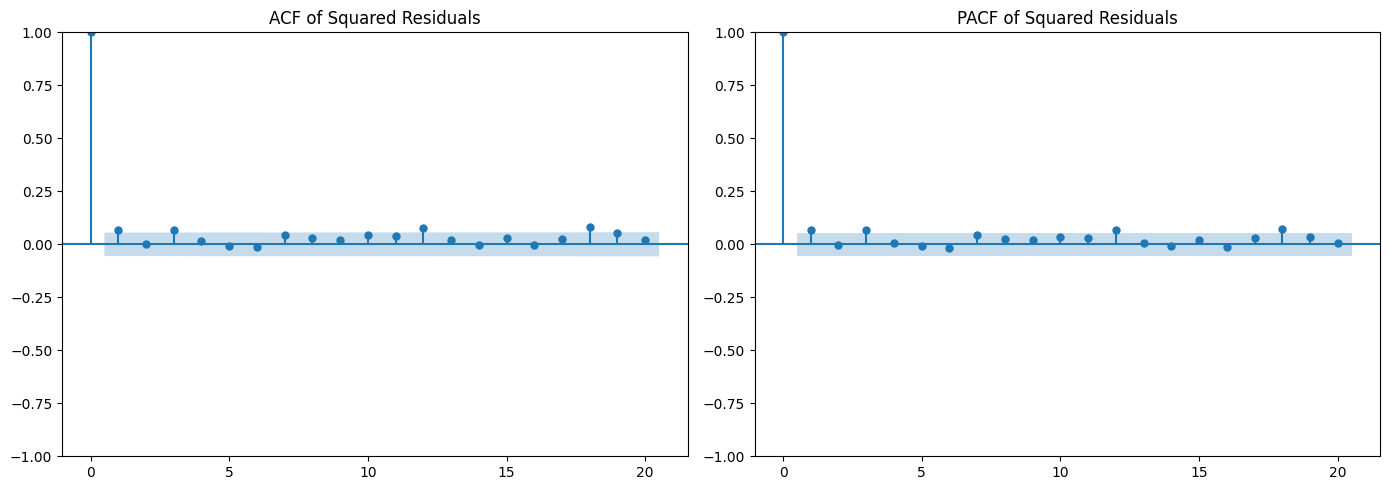

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_acf(squared_residuals, lags=20, ax=plt.gca())
plt.title('ACF of Squared Residuals')

plt.subplot(1, 2, 2)
plot_pacf(squared_residuals, lags=20, ax=plt.gca(), method='ywm')
plt.title('PACF of Squared Residuals')

plt.tight_layout()
plt.show()